In [1]:
# Importing Modules
import pandas as pd
import numpy as np

import transformers
import logging
transformers.logging.get_verbosity = lambda: logging.NOTSET

from transformers import BertTokenizer
from transformers import TFAutoModel

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
# Import Test Dataset
test = pd.read_csv('data/test.csv', header=None, sep=';', quotechar="'", names=['group', 'text'])

print(test)

print(test.text[0])

              group                                               text
0        Wirtschaft  Die Gewerkschaft GPA-djp lanciert den "All-in-...
1             Sport  Franzosen verteidigen 2:1-Führung – Kritische ...
2               Web  Neues Video von Designern macht im Netz die Ru...
3             Sport  23-jähriger Brasilianer muss vier Spiele pausi...
4     International  Aufständische verwendeten Chemikalie bei Gefec...
...             ...                                                ...
1023            Web  Programm "Ebay Plus" soll Ende September start...
1024         Inland  Fehlerhafte Bilanz 2013, Partei will berufen –...
1025          Sport  Als erster Olympia-Champion auch Hawaii-Sieger...
1026          Sport  Der Außenseiter aus Denver gewinnt die 50. Sup...
1027            Web  Wohl keine Einschränkungen bei Google-Services...

[1028 rows x 2 columns]
Die Gewerkschaft GPA-djp lanciert den "All-in-Rechner" und findet, dass die Vertragsform auf die Führungsebene beschränkt g

In [3]:
# Import Train Dataset
train = pd.read_csv('data/train.csv', header=None, sep=';', quotechar="'", names=['group', 'text'])

print(train)

print(train.text[0])

              group                                               text
0             Sport  21-Jähriger fällt wohl bis Saisonende aus. Wie...
1            Kultur  Erfundene Bilder zu Filmen, die als verloren g...
2               Web  Der frischgekürte CEO Sundar Pichai setzt auf ...
3        Wirtschaft  Putin: "Einigung, dass wir Menge auf Niveau vo...
4            Inland  Estland sieht den künftigen österreichischen P...
...             ...                                                ...
9240         Inland  Bernd Saurer war Bridge-Juniorenweltmeister un...
9241  International  Sandhere soll in vergangener Woche bei Luftang...
9242     Wirtschaft  Derzeit Konzeptgruppe in Berlin – Kein Komment...
9243         Inland  Landeshauptmann will den vierten Regierungssit...
9244       Panorama  Er ist einer von Millionen syrischen Flüchtlin...

[9245 rows x 2 columns]
21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten

In [4]:
# Initialize BERT Transformer Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

SEQ_LEN = 512 #maximum sequence length for BERT is 512

In [5]:
# Tokens for every line in Train Dataset
Xids = np.zeros((len(train), SEQ_LEN)) # init train ids
Xmask = np.zeros((len(train), SEQ_LEN)) # init train mask

for ind, seq in enumerate(train.text):
    tokens = tokenizer.encode_plus(seq, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
    Xids[ind,:], Xmask[ind,:] = tokens.input_ids, tokens.attention_mask

print(Xids)
print(Xmask)

[[3.0000e+00 2.4390e+03 2.6935e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.0000e+00 1.3190e+04 5.9200e+02 ... 3.9660e+03 2.6914e+04 4.0000e+00]
 [3.0000e+00 2.3300e+02 1.7580e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [3.0000e+00 1.1813e+04 3.1800e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.0000e+00 1.1680e+03 2.6748e+04 ... 1.0377e+04 6.5020e+03 4.0000e+00]
 [3.0000e+00 1.7700e+02 1.2700e+02 ... 1.4700e+02 2.6610e+03 4.0000e+00]]
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [6]:
# Tokens for Test Dataset
Tids = np.zeros((len(test), SEQ_LEN)) # init test ids
Tmask = np.zeros((len(test), SEQ_LEN)) # init test mask

for ind, seq in enumerate(test.text):
    tokens = tokenizer.encode_plus(seq, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
    Tids[ind,:], Tmask[ind,:] = tokens.input_ids, tokens.attention_mask

In [7]:
# One hot encoding the label classes of the trainigs data (with sklearn one hot encoder)
label = LabelEncoder()
label.fit(train.group)
int_data = label.transform(train.group)
int_data = int_data.reshape(len(int_data), 1)

onehot = OneHotEncoder(sparse=False)
onehot.fit(int_data)
onehot_train = onehot.transform(int_data)


print(f'Original labels:\n{train.group}')
print(f'One hot encoded:\n{onehot_train}')
print(sorted(set(train.group))) #we expect the one hot encoding to be encode the labels in a sorted manner
print(onehot_train[0], train.group[0]) #should be equal to Sport
print(len(set(train.group)) == len(onehot_train[0])) #should be equal

Original labels:
0               Sport
1              Kultur
2                 Web
3          Wirtschaft
4              Inland
            ...      
9240           Inland
9241    International
9242       Wirtschaft
9243           Inland
9244         Panorama
Name: group, Length: 9245, dtype: object
One hot encoded:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web', 'Wirtschaft', 'Wissenschaft']
[0. 0. 0. 0. 0. 1. 0. 0. 0.] Sport
True


In [8]:
# One hot encoding the label classes of the test data (with sklearn one hot encoder)
int_data = label.transform(test.group)
int_data = int_data.reshape(len(int_data), 1)

onehot_test = onehot.transform(int_data)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, onehot_train))  # create train tensor dataset 
test_dataset = tf.data.Dataset.from_tensor_slices((Tids, Tmask, onehot_test))  # create test tensor dataset

for data in train_dataset.take(1):
    print(data)

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([3.0000e+00, 2.4390e+03, 2.6935e+04, 1.1200e+02, 3.5200e+02,
       5.1900e+02, 5.4830e+03, 2.2940e+03, 2.5500e+02, 1.3936e+04,
       1.4700e+02, 2.6914e+04, 2.3190e+03, 2.0000e+00, 1.2031e+04,
       4.2800e+02, 1.0800e+03, 2.2940e+03, 2.5500e+02, 1.3936e+04,
       1.1500e+02, 4.6680e+03, 1.4920e+04, 2.9340e+03, 3.0750e+03,
       7.5320e+03, 2.6908e+04, 1.1721e+04, 2.6914e+04, 2.3300e+02,
       1.0600e+02, 2.9420e+03, 1.4700e+02, 2.1080e+04, 3.9340e+03,
       2.6897e+04, 2.4390e+03, 2.6935e+04, 1.1200e+02, 3.5200e+02,
       2.8800e+02, 1.4201e+04, 7.8500e+02, 1.1310e+03, 2.6964e+04,
       4.0000e+02, 2.6935e+04, 2.1040e+03, 2.0132e+04, 1.5904e+04,
       3.8300e+02, 1.7240e+03, 1.0859e+04, 2.6903e+04, 3.2210e+03,
       1.8280e+03, 6.6580e+03, 1.8050e+04, 2.7000e+02, 2.3500e+02,
       5.1800e+03, 3.0300e+02, 7.1700e+02, 8.2460e+03, 9.1000e+01,
       2.8790e+03, 4.4330e+03, 1.6000e+01, 1.0600e+02, 6.8550e+03,
       1.3163

In [10]:
# create dataset for BERT input
def _map_func(ids, masks, labels):
    return {'input_ids': ids, 'attention_mask': masks}, labels

train_dataset = train_dataset.map(_map_func)
test_dataset = test_dataset.map(_map_func)

for data in train_dataset.take(1):
    print(data)

({'input_ids': <tf.Tensor: shape=(512,), dtype=float64, numpy=
array([3.0000e+00, 2.4390e+03, 2.6935e+04, 1.1200e+02, 3.5200e+02,
       5.1900e+02, 5.4830e+03, 2.2940e+03, 2.5500e+02, 1.3936e+04,
       1.4700e+02, 2.6914e+04, 2.3190e+03, 2.0000e+00, 1.2031e+04,
       4.2800e+02, 1.0800e+03, 2.2940e+03, 2.5500e+02, 1.3936e+04,
       1.1500e+02, 4.6680e+03, 1.4920e+04, 2.9340e+03, 3.0750e+03,
       7.5320e+03, 2.6908e+04, 1.1721e+04, 2.6914e+04, 2.3300e+02,
       1.0600e+02, 2.9420e+03, 1.4700e+02, 2.1080e+04, 3.9340e+03,
       2.6897e+04, 2.4390e+03, 2.6935e+04, 1.1200e+02, 3.5200e+02,
       2.8800e+02, 1.4201e+04, 7.8500e+02, 1.1310e+03, 2.6964e+04,
       4.0000e+02, 2.6935e+04, 2.1040e+03, 2.0132e+04, 1.5904e+04,
       3.8300e+02, 1.7240e+03, 1.0859e+04, 2.6903e+04, 3.2210e+03,
       1.8280e+03, 6.6580e+03, 1.8050e+04, 2.7000e+02, 2.3500e+02,
       5.1800e+03, 3.0300e+02, 7.1700e+02, 8.2460e+03, 9.1000e+01,
       2.8790e+03, 4.4330e+03, 1.6000e+01, 1.0600e+02, 6.8550e+03,

In [11]:
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(32, drop_remainder=True)  # shuffle and batch trainings data
test_dataset = test_dataset.shuffle(len(test_dataset)).batch(32, drop_remainder=True)  # shuffle and batch test data

for data in train_dataset.take(1):
    print(data)

({'input_ids': <tf.Tensor: shape=(32, 512), dtype=float64, numpy=
array([[3.0000e+00, 1.9620e+03, 8.1000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 5.6630e+03, 2.3200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 2.6148e+04, 1.8890e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [3.0000e+00, 5.4060e+03, 2.4700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 4.2420e+03, 2.6935e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 3.3900e+03, 2.1000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])>, 'attention_mask': <tf.Tensor: shape=(32, 512), dtype=float64, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])>}, <tf.Tensor: shape=(32, 9), dtype=float64, 

In [12]:
bert = TFAutoModel.from_pretrained('bert-base-german-cased')  # initialize BERT model
bert.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109081344 
Total params: 109,081,344
Trainable params: 109,081,344
Non-trainable params: 0
_________________________________________________________________


In [26]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')  # initialize input_ids as a model layer
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')  # init attention_mask as a model layer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # create BERT model with input_id and attention_mask

X = tf.keras.layers.Dense(1024, activation='relu')(embeddings)  # linear layer
y = tf.keras.layers.Dense(len(onehot_train[0]), activation='softmax', name='outputs')(X)  # softmax for classification problem

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)  # convert layers to a model

model.layers[2].trainable=False  # do not train BERT as it slows down the training

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109081344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         787456      bert[1][1]                 

In [27]:
# parameters from: https://arxiv.org/pdf/1905.05583.pdf | https://arxiv.org/pdf/1907.11692v1.pdf
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-6)  # init ADAM as optimizer
loss = tf.keras.losses.CategoricalCrossentropy()  # init Categorical Crossentropy as loss function
metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes=len(onehot_train[0]), name='macro_average'), tfa.metrics.F1Score(average='micro', num_classes=len(onehot_train[0]), name='micro_average')]  # define metrics (accuracy, macro F1, micro F1)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  # compile model with optimizer, loss and metrics

In [28]:
# train BERT model and validate each epoch with the test dataset, save the training steps in history
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=4)

Epoch 1/4
288/288 [==============================] - ETA: 0s - loss: 1.6558 - accuracy: 0.5086 - macro_average: 0.4157 - micro_average: 0.5086 

/home/chris/anaconda3/envs/LS1_nlp/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


288/288 [==============================] - 5456s 19s/step - loss: 1.6558 - accuracy: 0.5086 - macro_average: 0.4157 - micro_average: 0.5086 - val_loss: 1.2758 - val_accuracy: 0.6406 - val_macro_average: 0.5795 - val_micro_average: 0.6406
Epoch 2/4
288/288 [==============================] - 8937s 31s/step - loss: 1.1282 - accuracy: 0.6860 - macro_average: 0.6520 - micro_average: 0.6860 - val_loss: 0.9537 - val_accuracy: 0.7344 - val_macro_average: 0.6933 - val_micro_average: 0.7344
Epoch 3/4
288/288 [==============================] - 4409s 15s/step - loss: 0.9213 - accuracy: 0.7270 - macro_average: 0.7048 - micro_average: 0.7270 - val_loss: 0.8226 - val_accuracy: 0.7490 - val_macro_average: 0.7203 - val_micro_average: 0.7490
Epoch 4/4
288/288 [==============================] - 4936s 17s/step - loss: 0.8176 - accuracy: 0.7538 - macro_average: 0.7393 - micro_average: 0.7538 - val_loss: 0.7434 - val_accuracy: 0.7646 - val_macro_average: 0.7446 - val_micro_average: 0.7646


In [29]:
#model.save('bert_512_adam')  # save the trained model

/home/chris/anaconda3/envs/LS1_nlp/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: bert_250_adam/assets


INFO:tensorflow:Assets written to: bert_250_adam/assets


In [30]:
#model = tf.keras.models.load_model('bert_512_adam')  # load the model

In [37]:
# function for auto tokenization of a text string

def tokenize_data(text, tokenizer=BertTokenizer.from_pretrained('bert-base-german-cased')):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64), 
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [32]:
# make predictions with the model on the tokenized data

def make_prediction(tokenized_data, model=model, groups=train.group):
    probs = model.predict(tokenized_data)[0]
    return sorted(set(groups))[np.argmax(probs)]

In [68]:
test.iloc[100]

group                                                  Web
text     Die neue Akkuhülle ist nicht das einzige Produ...
Name: 100, dtype: object

In [69]:
new_test = tokenize_data(test.text[100])  # tokenize data

In [70]:
make_prediction(new_test)  # predict tokenized data

'Web'

In [75]:
for num in range(30):
    new_test = tokenize_data(test.text[50+num])
    print(test.iloc[50+num])
    print(f'Real Class: {test.group[50+num]}\nPredicted Class: {make_prediction(new_test)}\n\n')

group                                               Inland
text     Was Johanna Mikl-Leitner (ÖVP) und Hans Peter ...
Name: 50, dtype: object
Real Class: Inland
Predicted Class: Inland


group                                        International
text     Privater Besuch ohne Öffentlichkeit – Politike...
Name: 51, dtype: object
Real Class: International
Predicted Class: Wirtschaft


group                                         Wissenschaft
text     Feierlichkeiten zum Jubiläum des wichtigen Ver...
Name: 52, dtype: object
Real Class: Wissenschaft
Predicted Class: Panorama


group                                                  Web
text     Wired und Reviewed haben aus ihren Tests die b...
Name: 53, dtype: object
Real Class: Web
Predicted Class: Web


group                                             Panorama
text     Problem der Verbindlichkeit angesichts ständig...
Name: 54, dtype: object
Real Class: Panorama
Predicted Class: Panorama


group                                         Wi

In [111]:
#Confusion Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
train.group

0          Wirtschaft
1               Sport
2                 Web
3               Sport
4       International
            ...      
1023              Web
1024           Inland
1025            Sport
1026            Sport
1027              Web
Name: group, Length: 1028, dtype: object

In [81]:
# predict all classes from the test data
predicted_class = list()
for text in test.text:
    predicted_class.append(make_prediction(tokenize_data(text)))

In [147]:
#encode actual class for confusion matrix
label = LabelEncoder()
label.fit(train.group)
int_data_act = label.transform(test.group)
int_data_act = int_data_act.reshape(len(int_data_act), 1)

#encode predicted class for confusion matrix
int_data_pred = label.transform(predicted_class)
int_data_pred = int_data_pred.reshape(len(int_data_pred), 1)

In [148]:
#create confusion matrix
data = {'y_Actual': np.ravel(int_data_act).tolist(),
        'y_Predicted': np.ravel(int_data_pred).tolist()}

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

In [142]:
confusion_matrix  # pandas confusion matrix

Predicted,0,1,2,3,4,5,6,7,8,All
Actual,,,,,,,,,,
0,27,7,3,5,8,0,7,10,0,67
1,2,70,2,0,14,0,1,8,5,102
2,0,1,137,0,6,0,1,4,2,151
3,4,1,2,37,2,0,2,2,4,54
4,1,7,24,3,114,0,4,11,4,168
5,0,0,2,1,3,112,0,2,0,120
6,0,1,6,0,3,0,148,8,2,168
7,0,10,7,0,16,0,10,97,1,141
8,0,1,2,0,3,1,5,2,43,57


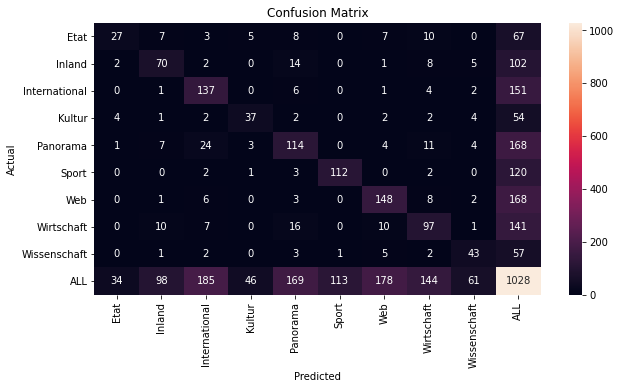

In [149]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, xticklabels=(sorted(set(test.group)) + ['ALL']), yticklabels=(sorted(set(test.group)) + ['ALL']),fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#TP 785
#TPR 0.76